# Machine Learning Pipeline - Production

Check the python kernel we are using, should be the local one, not the one in the virtual environment. <br>
NOTE: A proper virtual environment will be setup later on

In [1]:
import sys
print(sys.executable)

/usr/bin/python3


In [2]:
import os
print(os.getcwd())

/home/ieo7429/Desktop/THESIS_GAB/ML/MultiClassification


## Define Variables

Set up main variables that will be called later on, for readibility purposes

In [3]:
install_bool = False
path_to_datasets = "/home/ieo7429/Desktop/THESIS_GAB/outfiles/target_variables/sc_ML_tables_regression_classification_BRCA_1Mbp_with_HIC_and_Repliseq.RData"

mode = "regrout"
technology = "sc"

if technology == "sc":
    
    cols_to_drop = ["mean_log2FC", "joint_probability", "bool_diff_acc", 
                    "sign_mean_log2FC_1", "sign_mean_log2FC_2", "sign_mean_log2FC_3", 
                    "weighted_coef_of_var_log2FC", "weighted_log2FC", "bin", "Type", "replication_class"]

    cols_to_check = ["mean_log2FC", "weighted_log2FC", "weighted_coef_of_var_log2FC",
                 "joint_probability", "bool_diff_acc", "sign_mean_log2FC_1", 
                 "sign_mean_log2FC_2", "sign_mean_log2FC_3", "joined_direction", "significant_dir_1"]

else:
    
    cols_to_drop = ["bool_diff_acc", 
                    "sign_mean_log2FC_1", "sign_mean_log2FC_2", "sign_mean_log2FC_3", 
                    "bin", "Type", "replication_class"]

    cols_to_check = ["logFC", "bool_diff_acc", "sign_mean_log2FC_1", 
                 "sign_mean_log2FC_2", "sign_mean_log2FC_3", "joined_direction"]

if "ampl_score" in cols_to_drop and "del_score" in cols_to_drop:

    condition = "without_CNA"

else:

    condition = "with CNA"

n_jobs_boost = 60
n_jobs_sk = 1
n_iter_bsearch = 25
n_iter_rsearch = 50

split_random_state = 489574
classifier_seed = 3737
classifier_random_state = 39473209
hypertune_random_state_bsearch = 3847
hypertune_random_state_rsearch = 49574
kfold_random_state = 4909

outer_cv = 5
inner_cv = 3
plot_variation = True
plot_shap = True

import os

X_train_filename = "sc_MultiClassification_Output_with_HIC_and_Repliseq_1Mbp/multiclass_X_train_red"; 
X_test_filename = "sc_MultiClassification_Output_with_HIC_and_Repliseq_1Mbp/multiclass_X_test_red"
y_train_filename = "sc_MultiClassification_Output_with_HIC_and_Repliseq_1Mbp/multiclass_y_train_red"; 
y_test_filename = "sc_MultiClassification_Output_with_HIC_and_Repliseq_1Mbp/multiclass_y_test_red"
bin_train_filename = "sc_MultiClassification_Output_with_HIC_and_Repliseq_1Mbp/multiclass_bin_train_red"; 
bin_test_filename = "sc_MultiClassification_Output_with_HIC_and_Repliseq_1Mbp/multiclass_bin_test_red"
model_filename = "sc_MultiClassification_Output_with_HIC_and_Repliseq_1Mbp/multiclass_final_model"

file_paths = [
    X_train_filename, X_test_filename,
    y_train_filename, y_test_filename,
    bin_train_filename, bin_test_filename,
    model_filename
]

base_dirs = {os.path.dirname(path) for path in file_paths}

if len(base_dirs) != 1:
    raise ValueError(f"Inconsistent base directories found: {base_dirs}")

base_dir = base_dirs.pop()

if not os.path.exists(base_dir):
    raise FileNotFoundError(f"Base directory does not exist: {base_dir}")

print(f"Base directory is consistent and exists: {base_dir}")

Base directory is consistent and exists: sc_MultiClassification_Output_with_HIC_and_Repliseq_1Mbp


## Install packages

Install all needed packages

In [4]:
from IPython.display import clear_output

if install_bool:
    ! pip install pickleshare
    ! pip install pandas
    ! pip install scikit-learn
    ! pip install seaborn
    ! pip install scipy
    ! pip install --upgrade pip setuptools wheel
    ! pip install rpy2
    ! pip install shap
    ! pip install "numpy<=2.1"
    %pip install -U ipywidgets

clear_output(wait = False)

## Import libraries

Import all packages

In [5]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import rpy2.robjects as ro
import xgboost as xgb
import shap
import warnings
import pickleshare
import pickle
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from skopt import BayesSearchCV
from sklearn.feature_selection import SelectFromModel

## Define Functions

### load_datasets_from_r
Reads "ML.Tables" .Rdata file and converts it to a nested dictionary.

In [6]:
def load_datasets_from_r(file_path):

    """ 
    The function uses rpy2 to load datasets from an RData file.
    In particular it expects a list of data.frames
    It returns a dictionary of pandas DataFrames.
    """
    
    pandas2ri.activate()

    ro.r['load'](file_path) # load the .RData

    env = ro.globalenv # set the environment

    r_list = env[list(env.keys())[0]] # take the list object

    list_names = ro.r['names'](r_list) # take the names
    list_names = [str(name) for name in list_names]

    df_dict = {} # initialize outer dictionary
    with (ro.default_converter + ro.pandas2ri.converter).context(): # start the conversion
    # the conversion transforms a list of lists of lists of data.frames 
    # to a list of dictionaries of dictionaries of dictionaries of DataFrame
        i = 0
        for outer_dict in r_list:
            df_dict[list_names[i]] = outer_dict
            i += 1
            
    return(df_dict)

### gini_coefficient

Function to compute the gini coefficient (2 * AUC - 1)

In [7]:
def gini_coefficient_score(y_true, y_pred_prob, **kwargs):
    y_score = y_pred_prob
    auc_score = sk.metrics.roc_auc_score(y_true, y_score, multi_class='ovr')
    gini_coef = 2 * auc_score - 1
    return gini_coef

In [8]:
gini_coefficient = sk.metrics.make_scorer(gini_coefficient_score, response_method = "predict_proba", greater_is_better= True)

### feature_selector
his function performs Incremental Feature Selection (IFS) to produce a reduced model <br> with best gini coefficient (2 * AUC - 1) performance with cross validation.
Mean absolute SHAP values are used to select features

In [9]:
def feature_selector_shap(feature_names, feature_importances, model, 
                          X_train, X_test, y_train, inner_cv,
                          plot = True, verbose = True):

    """
    The function takes as input feature names, feature importances, 
    a XGBoost Classifier object, the training and test dataset
    and returns the reduced training and test datasets.
    - plot parameter regulates whether or not to plot the Gini Coefficient vs number of feature plot
    - verbose parameter regulates whether or not to produce a text output
    """

    thresholds = np.sort(feature_importances) # sort the feature importances
    num_features_list = [] # initialize list
    gini_coef_list = [] # initialize list
    
    for threshold in thresholds: # iterate over thresholds
        
        vars_to_keep = np.where(feature_importances >= threshold)[0]
        X_train_selected = X_train.iloc[:,vars_to_keep]

        gini_coef_scores = sk.model_selection.cross_val_score(estimator = model, 
                                                              X = X_train_selected, y = y_train, 
                                                              scoring = gini_coefficient, cv = inner_cv)
        mean_gini_coef_score = np.mean(gini_coef_scores)
        
        num_features_list.append(X_train_selected.shape[1]) # append
        gini_coef_list.append(mean_gini_coef_score) # append

        if verbose:
            print(f'> threshold={threshold}, features={X_train_selected.shape[1]}, gini coefficient={mean_gini_coef_score}')
        
        if len(vars_to_keep) == 1:
            break

    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(num_features_list, gini_coef_list, marker='o')
        plt.xlabel('Number of Selected Features')
        plt.ylabel('cross validated mean Ginny coefficient')
        plt.title('Gini coefficient vs. Number of Selected Features')
        plt.grid(True)
        plt.show()

    optimal_threshold_index = np.argmax(gini_coef_list)
    optimal_num_features = num_features_list[optimal_threshold_index]
    
    if (optimal_threshold_index) == 0:
        optimal_threshold = 0
    else:   
        optimal_threshold = thresholds[optimal_threshold_index - 1]

    if verbose:
        print(f"Optimal Threshold: {optimal_threshold:.4f}")
        print(f"Number of Selected Features: {optimal_num_features}")
        print(f"Gini coef at Optimal Threshold: {gini_coef_list[optimal_threshold_index]:.4f}")
        print("\n")
        
    n = 5
    selected_features = feature_names[np.where(feature_importances > optimal_threshold)]
    selected_features = [str(name) for name in selected_features]
    discarded_features = [str(name) for name in feature_names if str(name) not in selected_features]

    if verbose:
        print("Selected features are: \n")
        for i in range(0,len(selected_features), n):
            print("  ".join(selected_features[i:i+n]))
        print("\n")
        print("Discarded features are: \n")
        for i in range(0,len(discarded_features), n):
            print("  ".join(discarded_features[i:i+n]))

    X_train_reduced = X_train[selected_features]
    X_test_reduced = X_test[selected_features]
    
    return(X_train_reduced, X_test_reduced, selected_features)    

### Nested CV la vendetta

In [10]:
def nested_CV_revenge(outer_cv, inner_cv,
                      X_train, y_train, 
                      model, search_space, 
                      n_jobs, n_iter_bsearch, verbose):
    
    """
    The function performs nested cross validation to estimate model's error rate
    It take the cv number, the training dataset, the target variable, the model or a BayesSearchCV
    and a search space to perform hyperparameter tuning
    """
    
    kf = sk.model_selection.KFold(n_splits = outer_cv, 
                                  shuffle=True, 
                                  random_state = kfold_random_state)
    

    hyperparam_list = []
    selected_features_list = []
    accuracy_array = np.zeros(outer_cv)
    f1_array = np.zeros(outer_cv)
    precision_array = np.zeros(outer_cv)
    recall_array = np.zeros(outer_cv)
    roc_auc_array = np.zeros(outer_cv)
    predictions_array = np.zeros(len(X_train))
    probas_array = np.zeros((len(X_train),len(np.unique(y_train))))
    
    i = 0
    for train_index, val_index in kf.split(X_train):

        if verbose:
            print(f"Fold #{i + 1}")
            
        if verbose:
            print("STEP 1 (Splitting)")
            
        X_train_cv, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_cv, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        if verbose:
            print("STEP 2 (Tuning)")

        if verbose:
            print("STEP 2.1 (HyperParameter Tuning Part 1)")
        
        opti = BayesSearchCV(
            estimator = model,
            search_spaces = search_space,
            n_iter = n_iter_bsearch,
            cv = inner_cv,
            random_state = hypertune_random_state_bsearch,
            refit = True,
            n_jobs = n_jobs,
            verbose = 3
        )
        
        opti.fit(X_train_cv, y_train_cv)
        best_model = opti.best_estimator_

        if verbose:
            print("STEP 2.2 (SHAP)")
        
        explainer = shap.TreeExplainer(best_model)

        feature_names = best_model.feature_names_in_
        feature_importances_shap = np.mean(np.mean(np.abs(explainer.shap_values(X_train_cv)), axis = 0), axis = 1)
    
        if verbose:
            print("STEP 2.3 (Feature selection)")
        
        X_train_cv_reduced, X_val_cv_reduced, selected_features = feature_selector_shap(feature_names, feature_importances_shap, 
                                                                                        best_model, 
                                                                                        X_train_cv, X_val, y_train_cv,
                                                                                        inner_cv,
                                                                                        plot = False, verbose = False)

        if verbose:
            print("STEP 2.4 (HyperParameter Tuning Part 2)")
        
        opti_fs = BayesSearchCV(
            estimator = best_model, 
            search_spaces = search_space, 
            n_iter = n_iter_bsearch, 
            cv = inner_cv,
            random_state = hypertune_random_state_bsearch,
            refit = True, 
            n_jobs = n_jobs,
            verbose = 3
        )
        
        opti_fs.fit(X_train_cv_reduced, y_train_cv)
        best_model_fs = opti_fs.best_estimator_
        best_params_fs = opti_fs.best_params_
        
        if verbose:
            print("STEP 3 (Prediction)")
        
        cv_predictions = best_model_fs.predict(X_val_cv_reduced)
        cv_pred_probas = best_model_fs.predict_proba(X_val_cv_reduced)
        
        cv_accuracy = sk.metrics.accuracy_score(y_val, cv_predictions)
        cv_f1 = sk.metrics.f1_score(y_val, cv_predictions, average = "macro")
        cv_precision = sk.metrics.precision_score(y_val, cv_predictions, average = "macro")
        cv_recall = sk.metrics.recall_score(y_val, cv_predictions, average = "macro")
        cv_roc_auc = sk.metrics.roc_auc_score(y_val, cv_pred_probas, multi_class='ovr', average = "macro")
        
        hyperparam_list.append(best_params_fs)
        selected_features_list.append(selected_features)
        accuracy_array[i] = cv_accuracy 
        f1_array[i] = cv_f1
        precision_array[i] = cv_precision
        recall_array[i] = cv_recall
        roc_auc_array[i] = cv_roc_auc
        predictions_array[val_index] = cv_predictions
        probas_array[val_index] = cv_pred_probas
        
        i += 1

    return(hyperparam_list, selected_features_list, 
           accuracy_array, f1_array, precision_array, 
           recall_array, roc_auc_array, predictions_array, probas_array)

## Load Data

In [11]:
output_dict = load_datasets_from_r(path_to_datasets)

In [12]:
working_df = output_dict[mode]

In [13]:
working_df.head()

,bin,joint_probability,bool_diff_acc,sign_mean_log2FC_1,sign_mean_log2FC_2,sign_mean_log2FC_3,mean_log2FC,weighted_log2FC,weighted_coef_of_var_log2FC,Type,...,9_70,3_156,7_57,8_69,11_89,2_23,20_36,11_87,log2smoothed,replication_class
1,1_10,8.448318e-15,1,-1,0,0,0.013808,0.005178,0.016220,BRCA,...,-1.0472,-0.4076,-0.8290,0.9838,-0.3728,-0.7466,0.3955,-0.7033,1.841601,E
2,1_100,9.999943e-01,0,-1,0,0,-0.078535,0.000000,0.000000,BRCA,...,-0.3371,-0.0768,0.8638,0.3581,-0.6134,0.3856,-0.1782,-0.9056,-1.305504,L
3,1_103,4.107589e-01,0,-1,0,0,0.043472,0.005434,0.010190,BRCA,...,-0.6507,0.1925,-1.0208,0.1022,0.0110,-0.9244,-0.6938,0.2239,-2.453735,L
4,1_105,1.002559e-06,1,1,0,0,1.049167,0.393438,0.518994,BRCA,...,-0.1348,0.3717,2.7372,-0.0992,0.7334,1.8498,-0.2913,1.5003,-2.021942,L
5,1_106,1.301741e-07,1,1,0,0,0.677868,0.254201,0.520645,BRCA,...,-1.5012,3.5566,0.6990,0.2633,1.4566,2.4032,-0.5481,2.1821,-1.971711,L


In [14]:
significant_dir_1 = np.where(
    (working_df.bool_diff_acc == 1) & (working_df.sign_mean_log2FC_1 == 1), 2,
    np.where(
        (working_df.bool_diff_acc == 1) & (working_df.sign_mean_log2FC_1 == -1), 0, 1
    )
)

In [15]:
working_df["significant_dir_1"] = significant_dir_1

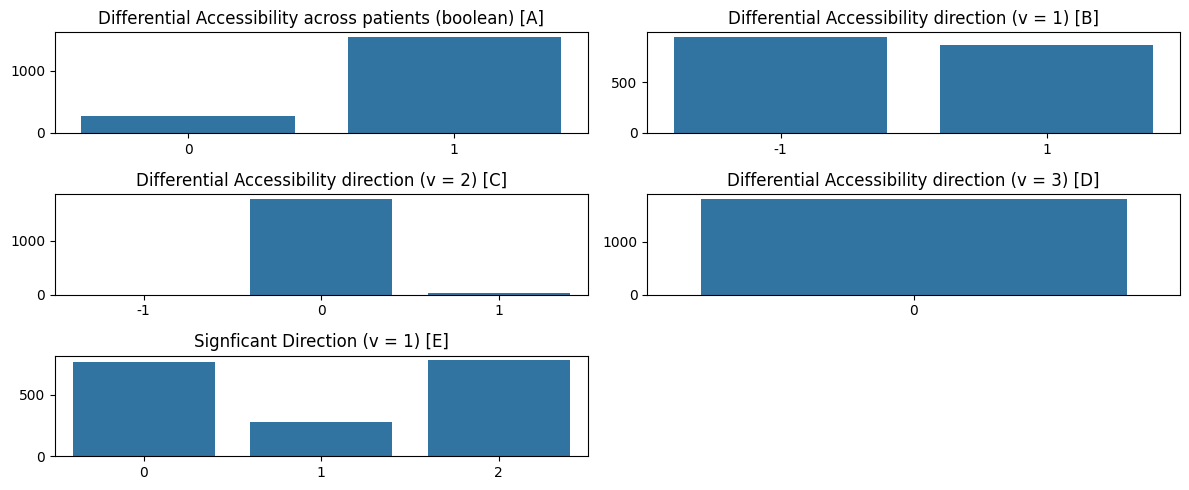

In [16]:
fig, axes = plt.subplots(3, 2, figsize=(12, 5))

A = axes[0,0]
B = axes[0,1]
C = axes[1,0]
D = axes[1,1]
E = axes[2,0]
F = axes[2,1]

sns.barplot(working_df.bool_diff_acc.value_counts(), ax = A)
sns.barplot(working_df.sign_mean_log2FC_1.value_counts(), ax = B)
sns.barplot(working_df.sign_mean_log2FC_2.value_counts(), ax = C)
sns.barplot(working_df.sign_mean_log2FC_3.value_counts(), ax = D)
sns.barplot(working_df.significant_dir_1.value_counts(), ax = E)


A.set_title("Differential Accessibility across patients (boolean) [A]")
B.set_title("Differential Accessibility direction (v = 1) [B]")
C.set_title("Differential Accessibility direction (v = 2) [C]")
D.set_title("Differential Accessibility direction (v = 3) [D]")
E.set_title("Signficant Direction (v = 1) [E]")

A.set_xlabel(""); A.set_ylabel("")
B.set_xlabel(""); B.set_ylabel("")
C.set_xlabel(""); C.set_ylabel("")
D.set_xlabel(""); D.set_ylabel("")
E.set_xlabel(""); E.set_ylabel("")

F.axis('off')

plt.tight_layout()

## Prepare Data

In [17]:
bin_ids = working_df[["bin"]]

In [18]:
working_df = working_df.drop(cols_to_drop, axis= 1)

In [19]:
working_df.head()

,ampl_score,del_score,mean.GC.content,total_n_partners.trans,total_n_PPIs.trans_IntINSIDER,total_n_ohnologs.mmpaper_trans,total_n_paralogs_trans,dist.to.closest.FGS,Length_Counts.E1,Length_Counts.E10,...,9_70,3_156,7_57,8_69,11_89,2_23,20_36,11_87,log2smoothed,significant_dir_1
1,0.044986,0.320525,50.325833,2.0,52.0,10.0,35.0,61789940.0,5400.0,22800.0,...,-1.0472,-0.4076,-0.8290,0.9838,-0.3728,-0.7466,0.3955,-0.7033,1.841601,0
2,0.075914,0.243674,36.060000,0.0,12.0,1.0,2.0,26299595.0,1000.0,1400.0,...,-0.3371,-0.0768,0.8638,0.3581,-0.6134,0.3856,-0.1782,-0.9056,-1.305504,1
3,0.074039,0.234302,35.120000,0.0,6.0,6.0,4.0,29302613.0,0.0,0.0,...,-0.6507,0.1925,-1.0208,0.1022,0.0110,-0.9244,-0.6938,0.2239,-2.453735,1
4,0.079663,0.226804,34.336000,0.0,5.0,NaN,0.0,31304625.0,0.0,0.0,...,-0.1348,0.3717,2.7372,-0.0992,0.7334,1.8498,-0.2913,1.5003,-2.021942,2
5,0.079663,0.219306,NaN,NaN,NaN,NaN,NaN,32305631.0,0.0,0.0,...,-1.5012,3.5566,0.6990,0.2633,1.4566,2.4032,-0.5481,2.1821,-1.971711,2


In [20]:
X = working_df.iloc[:, 0:-1]
y = working_df.iloc[:, -1]

In [21]:
X.head()

,ampl_score,del_score,mean.GC.content,total_n_partners.trans,total_n_PPIs.trans_IntINSIDER,total_n_ohnologs.mmpaper_trans,total_n_paralogs_trans,dist.to.closest.FGS,Length_Counts.E1,Length_Counts.E10,...,16_48,9_70,3_156,7_57,8_69,11_89,2_23,20_36,11_87,log2smoothed
1,0.044986,0.320525,50.325833,2.0,52.0,10.0,35.0,61789940.0,5400.0,22800.0,...,-0.2305,-1.0472,-0.4076,-0.8290,0.9838,-0.3728,-0.7466,0.3955,-0.7033,1.841601
2,0.075914,0.243674,36.060000,0.0,12.0,1.0,2.0,26299595.0,1000.0,1400.0,...,0.0655,-0.3371,-0.0768,0.8638,0.3581,-0.6134,0.3856,-0.1782,-0.9056,-1.305504
3,0.074039,0.234302,35.120000,0.0,6.0,6.0,4.0,29302613.0,0.0,0.0,...,0.0448,-0.6507,0.1925,-1.0208,0.1022,0.0110,-0.9244,-0.6938,0.2239,-2.453735
4,0.079663,0.226804,34.336000,0.0,5.0,NaN,0.0,31304625.0,0.0,0.0,...,1.3479,-0.1348,0.3717,2.7372,-0.0992,0.7334,1.8498,-0.2913,1.5003,-2.021942
5,0.079663,0.219306,NaN,NaN,NaN,NaN,NaN,32305631.0,0.0,0.0,...,0.9841,-1.5012,3.5566,0.6990,0.2633,1.4566,2.4032,-0.5481,2.1821,-1.971711


In [22]:
if len([col for col in cols_to_check if col in X.columns]) > 0:
    raise Exception("Target Variable and derivated in the training set!")
else:
    print("Target Variable outside training set!")

Target Variable outside training set!


In [23]:
X.columns

Index(['ampl_score', 'del_score', 'mean.GC.content', 'total_n_partners.trans',
       'total_n_PPIs.trans_IntINSIDER', 'total_n_ohnologs.mmpaper_trans',
       'total_n_paralogs_trans', 'dist.to.closest.FGS', 'Length_Counts.E1',
       'Length_Counts.E10',
       ...
       '16_48', '9_70', '3_156', '7_57', '8_69', '11_89', '2_23', '20_36',
       '11_87', 'log2smoothed'],
      dtype='object', length=252)

In [24]:
X_train, X_test, y_train, y_test, bin_train, bin_test = sk.model_selection.train_test_split(X, y, bin_ids, test_size=0.3, random_state=split_random_state)

## Prepare the Classifier and the Search Space

In [25]:
classifier = xgb.XGBClassifier(n_jobs = n_jobs_boost, seed = classifier_seed, random_state = classifier_random_state, tree_method = "hist", device = "cpu")

search_space_bayes = {
    'learning_rate': (0.01, 0.3),                     # conservative to prevent noisy learning
    'max_depth': (1, 14),                             # captures 4–6 feature interactions without overfitting
    'min_child_weight': (1, 50),                      # helps avoid splits on small samples
    'gamma': (0.1, 1.0, 'log-uniform'),               # require meaningful splits
    'subsample': (0.6, 1.0),                          # stabilize with row sampling
    'colsample_bytree': (0.5, 1.0),                   # feature subsampling per tree
    'colsample_bylevel': (0.5, 1.0),                  # feature subsampling per split level
    'reg_alpha': (1e-3, 10, 'log-uniform'),           # L1 penalty for sparsity
    'reg_lambda': (0.1, 100, 'log-uniform'),          # L2 penalty to reduce overfitting
    'max_delta_step': (0, 10),                        # improves convergence in imbalanced/unstable targets
    'n_estimators': (100, 500),                       # enough boosting rounds for complexity
    'objective': ['multi:softmax'],  
    'booster': ['gbtree', 'dart'],  
    'eval_metric': ['mlogloss', 'error', 'auc']
}

### NESTED CV PIPELINE

In [26]:
results = nested_CV_revenge(
    outer_cv, inner_cv,
    X_train=X_train,
    y_train=y_train,
    model=classifier,
    search_space=search_space_bayes,
    n_jobs= n_jobs_sk, n_iter_bsearch = n_iter_bsearch,
    verbose=True
)

(
    hyperparam_list,
    selected_features_list,
    accuracy_array,
    f1_array,
    precision_array,
    recall_array,
    roc_auc_array,
    predictions_array,
    probas_array
) = results

clear_output(wait = False)

In [27]:
print(f"The cross-validated accuracy (cv = {outer_cv}) is: {np.mean(accuracy_array)}")
print(f"The cross-validated f1 (cv = {outer_cv}) is: {np.mean(f1_array)}")
print(f"The cross-validated precision (cv = {outer_cv}) is: {np.mean(precision_array)}")
print(f"The cross-validated recall (cv = {outer_cv}) is: {np.mean(recall_array)}")
print(f"The cross-validated AUC (cv = {outer_cv}) is: {np.mean(roc_auc_array)}")

The cross-validated accuracy (cv = 5) is: 0.6771746911082756
The cross-validated f1 (cv = 5) is: 0.5240409691942821
The cross-validated precision (cv = 5) is: 0.5672203142642034
The cross-validated recall (cv = 5) is: 0.5483552779778004
The cross-validated AUC (cv = 5) is: 0.7904089253668614


In [28]:
selected_features_in_at_least_one_cv = set([elem for inner_list in selected_features_list for elem in inner_list])

In [29]:
search_space_grid = {}

for dictionary in hyperparam_list:
    for k,v in dictionary.items():
        if k in search_space_grid:
            search_space_grid[k].update([v])
        else:
            search_space_grid[k] = set([v])

search_space_grid = {k : list(v) for k,v in search_space_grid.items()}

## Full Dataset Hyperparameter Tuning

In [30]:
opti = sk.model_selection.RandomizedSearchCV(estimator = classifier, 
                                             param_distributions = search_space_grid, 
                                             cv = inner_cv, 
                                             n_jobs = n_jobs_sk,
                                             n_iter = n_iter_rsearch,
                                             random_state = hypertune_random_state_rsearch, 
                                             verbose = 0, refit = True)
opti.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device='cpu',
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrai...
                                        'objective': ['multi:softmax'],
                                        'reg_alpha': [0.14549582577894687,
                                                      0.014900242190610162,
                                                      0.0029949916204736644,
                                                      10.0,
                                                      0.011721722669367739],
                                        'reg_lambda': [0.5203411655062483,
                                                       0.2669840207965698,
                                                       0.12856312359450586,
                                                       4.225869278060716,
                                                       7.319717673230659],
                                        'subsample': [0.8543582000448856, 1.0,
                                                      0.8817406940448107,
                                                      0.9309426393172106,
                                                      0.8596580193924419]},
                   random_state=49574)

In [31]:
model = opti.best_estimator_

## Feature Importance Analysis

Let's look at both XGBoost native feature importance and at mean absolute SHAP values as metric of feature importance

In [32]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)
shap_values_numpy = explainer.shap_values(X_train)

regrout / with CNA


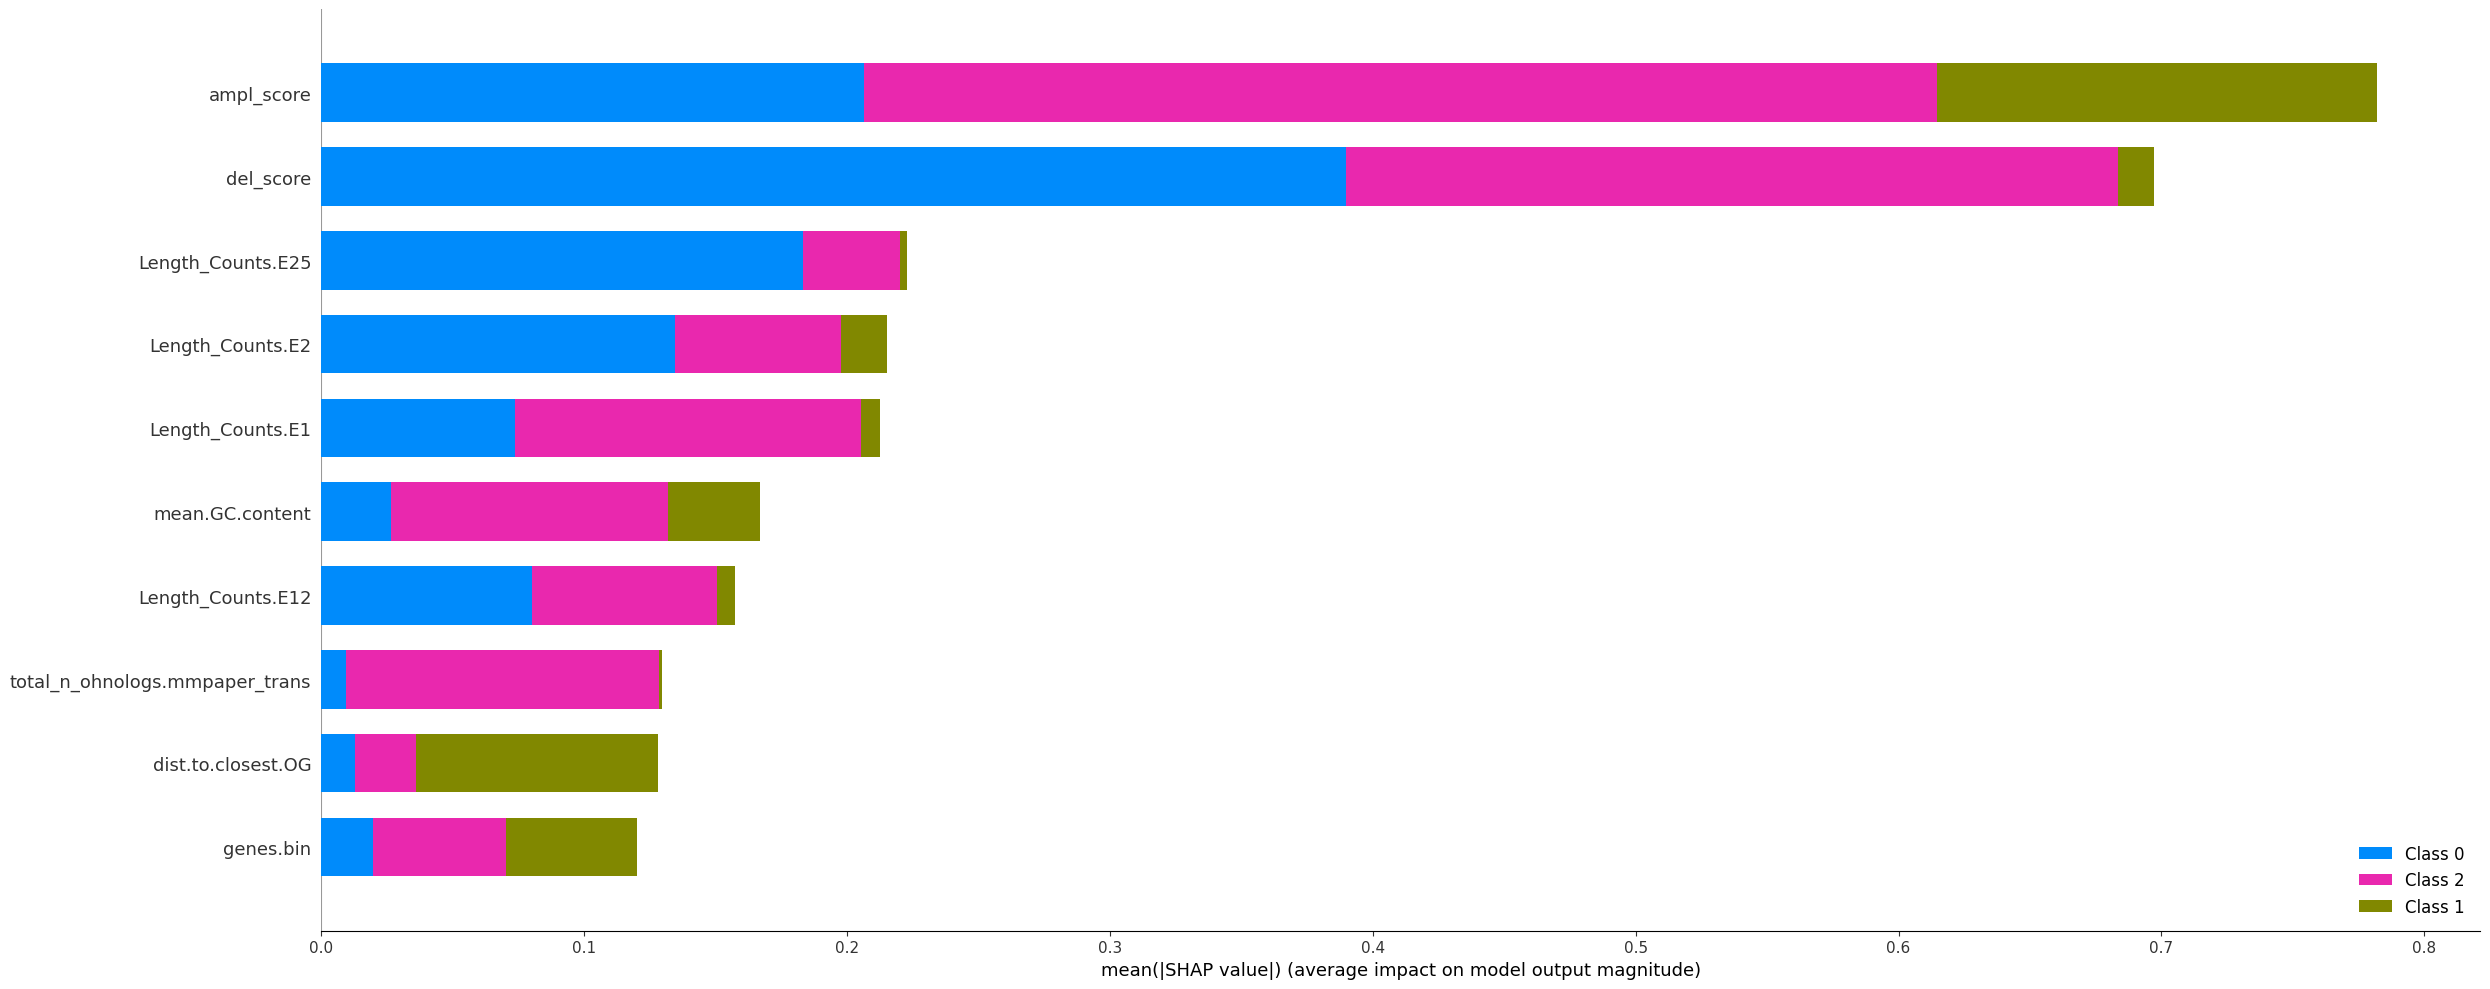

In [33]:
if plot_shap:
    print(" / ".join([mode, condition]))
    plt.figure(figsize = (100,25))
    summary_plot = shap.summary_plot(shap_values, X_train, 
                                     plot_type='bar', max_display=10, plot_size= (25,10))
    plt.show()

## Feature Selection

Let's perform Feature Selection using mean absolute SHAP values

> threshold=0.0, features=252, gini coefficient=0.557204873227443


> threshold=0.0, features=252, gini coefficient=0.557204873227443


> threshold=0.0, features=252, gini coefficient=0.557204873227443


> threshold=0.0006671653245575726, features=249, gini coefficient=0.554247129385073


> threshold=0.001170640462078154, features=248, gini coefficient=0.5607870062395373


> threshold=0.001179706770926714, features=247, gini coefficient=0.5488914106924335


> threshold=0.0013108733110129833, features=246, gini coefficient=0.5569528385934172


> threshold=0.001357566099613905, features=245, gini coefficient=0.5612487477484364


> threshold=0.0013614505296573043, features=244, gini coefficient=0.5648492130544843


> threshold=0.0013744592433795333, features=243, gini coefficient=0.5639945090238915


> threshold=0.0013832836411893368, features=242, gini coefficient=0.554288971239108


> threshold=0.0014886633725836873, features=241, gini coefficient=0.5567208297024641


> threshold=0.0015423274599015713, features=240, gini coefficient=0.5490868441397264


> threshold=0.0015618555480614305, features=239, gini coefficient=0.5652445924500665


> threshold=0.0016007479280233383, features=238, gini coefficient=0.5607329935165087


> threshold=0.001621173694729805, features=237, gini coefficient=0.5506527532221753


> threshold=0.0016288611805066466, features=236, gini coefficient=0.558229107152272


> threshold=0.0016521081561222672, features=235, gini coefficient=0.552494596850745


> threshold=0.0017102668061852455, features=234, gini coefficient=0.5512425099707255


> threshold=0.001736563048325479, features=233, gini coefficient=0.5604552376022681


> threshold=0.001760462881065905, features=232, gini coefficient=0.5548825954361526


> threshold=0.0017965392908081412, features=231, gini coefficient=0.550388111487109


> threshold=0.0018166847294196486, features=230, gini coefficient=0.5592693904668153


> threshold=0.001824268139898777, features=229, gini coefficient=0.5557114010082093


> threshold=0.0018440262647345662, features=228, gini coefficient=0.5544672950501498


> threshold=0.0018625707598403096, features=227, gini coefficient=0.5647414583607882


> threshold=0.0019278632244095206, features=226, gini coefficient=0.5521020623379538


> threshold=0.001947226352058351, features=225, gini coefficient=0.5524275974973232


> threshold=0.0019934556912630796, features=224, gini coefficient=0.5546870537468995


> threshold=0.002028333256021142, features=223, gini coefficient=0.5458866061517725


> threshold=0.0020425377879291773, features=222, gini coefficient=0.5614683762145467


> threshold=0.002099055564031005, features=221, gini coefficient=0.555913841062796


> threshold=0.0021652665454894304, features=220, gini coefficient=0.552469670890732


> threshold=0.0021970656234771013, features=219, gini coefficient=0.5504480352309394


> threshold=0.0022152650635689497, features=218, gini coefficient=0.562670479262687


> threshold=0.002232939936220646, features=217, gini coefficient=0.561812622840825


> threshold=0.002242319518700242, features=216, gini coefficient=0.5525592393239727


> threshold=0.002272233599796891, features=215, gini coefficient=0.5597272039015321


> threshold=0.0022906779777258635, features=214, gini coefficient=0.5579167668466773


> threshold=0.0023237280547618866, features=213, gini coefficient=0.556410736154727


> threshold=0.00232586357742548, features=212, gini coefficient=0.5542964511440152


> threshold=0.002352998359128833, features=211, gini coefficient=0.5602276588802452


> threshold=0.0025325834285467863, features=210, gini coefficient=0.5668999413853556


> threshold=0.002533103572204709, features=209, gini coefficient=0.5513306595071188


> threshold=0.0028300692792981863, features=208, gini coefficient=0.5661915794726163


> threshold=0.0028978262562304735, features=207, gini coefficient=0.5477081970101627


> threshold=0.00289793498814106, features=206, gini coefficient=0.55215722762455


> threshold=0.0029044728726148605, features=205, gini coefficient=0.5635431401590655


> threshold=0.002929468872025609, features=204, gini coefficient=0.5608220003578567


> threshold=0.0029390982817858458, features=203, gini coefficient=0.567273458272369


> threshold=0.0029447339475154877, features=202, gini coefficient=0.5615379597623806


> threshold=0.0030020636040717363, features=201, gini coefficient=0.5452926294073788


> threshold=0.003018077230080962, features=200, gini coefficient=0.5623961432758542


> threshold=0.003043870208784938, features=199, gini coefficient=0.5614674711232809


> threshold=0.003098871326074004, features=198, gini coefficient=0.5645476907689219


> threshold=0.0031308571342378855, features=197, gini coefficient=0.561922125567894


> threshold=0.003159809159114957, features=196, gini coefficient=0.5671003081507282


> threshold=0.0031799518037587404, features=195, gini coefficient=0.5591353391429543


> threshold=0.0031920999754220247, features=194, gini coefficient=0.5569779287290582


> threshold=0.003211809555068612, features=193, gini coefficient=0.5625095813123666


> threshold=0.003217128338292241, features=192, gini coefficient=0.5596239083951984


> threshold=0.003229730762541294, features=191, gini coefficient=0.5573681010811267


> threshold=0.0032330069225281477, features=190, gini coefficient=0.5669850106047245


> threshold=0.0032459089998155832, features=189, gini coefficient=0.5636856592907448


> threshold=0.003326947567984462, features=188, gini coefficient=0.5559136263101864


> threshold=0.0033391574397683144, features=187, gini coefficient=0.5568071243948972


> threshold=0.003351939143612981, features=186, gini coefficient=0.564770670688655


> threshold=0.003359202528372407, features=185, gini coefficient=0.5619110909667998


> threshold=0.0033616686705499887, features=184, gini coefficient=0.5667480948260397


> threshold=0.003370910184457898, features=183, gini coefficient=0.5563368414713433


> threshold=0.0034400366712361574, features=182, gini coefficient=0.5646058195978322


> threshold=0.0034578803461045027, features=181, gini coefficient=0.5621706165375713


> threshold=0.003488006303086877, features=180, gini coefficient=0.5605195374718575


> threshold=0.00349808600731194, features=179, gini coefficient=0.5705069508108657


> threshold=0.0035041961818933487, features=178, gini coefficient=0.5622639371206487


> threshold=0.0035077380016446114, features=177, gini coefficient=0.5609139584052836


> threshold=0.0035131871700286865, features=176, gini coefficient=0.5713356487635136


> threshold=0.0035901295486837626, features=175, gini coefficient=0.5740706021716148


> threshold=0.0035951733589172363, features=174, gini coefficient=0.5699352648024391


> threshold=0.003715071128681302, features=173, gini coefficient=0.5697834210416687


> threshold=0.0037288630846887827, features=172, gini coefficient=0.5667376341973539


> threshold=0.0037482839543372393, features=171, gini coefficient=0.5658241692951026


> threshold=0.0037563371006399393, features=170, gini coefficient=0.5709977722996287


> threshold=0.003816795302554965, features=169, gini coefficient=0.5625654003435588


> threshold=0.0038275800179690123, features=168, gini coefficient=0.561702600659094


> threshold=0.0038554181810468435, features=167, gini coefficient=0.5543011258568517


> threshold=0.0038876989856362343, features=166, gini coefficient=0.5684025363984198


> threshold=0.003957781009376049, features=165, gini coefficient=0.5656197442970456


> threshold=0.003960372880101204, features=164, gini coefficient=0.5687658642125794


> threshold=0.003991522826254368, features=163, gini coefficient=0.5829151117879775


> threshold=0.004000676330178976, features=162, gini coefficient=0.5640415608638285


> threshold=0.004058558028191328, features=161, gini coefficient=0.5718875305464448


> threshold=0.004077157471328974, features=160, gini coefficient=0.5715791390818924


> threshold=0.004100670572370291, features=159, gini coefficient=0.571318221122323


> threshold=0.004114409908652306, features=158, gini coefficient=0.5792414152000546


> threshold=0.004149432759732008, features=157, gini coefficient=0.5621519142351714


> threshold=0.004164332058280706, features=156, gini coefficient=0.5740872658864548


> threshold=0.004243550356477499, features=155, gini coefficient=0.5726359350706569


> threshold=0.0042442744597792625, features=154, gini coefficient=0.5722220174808192


> threshold=0.004275429528206587, features=153, gini coefficient=0.5712498414989161


> threshold=0.0044330726377666, features=152, gini coefficient=0.5633469790432483


> threshold=0.004449939820915461, features=151, gini coefficient=0.5697335825331711


> threshold=0.004473298322409391, features=150, gini coefficient=0.5737460517037127


> threshold=0.004613777156919241, features=149, gini coefficient=0.5668530175824832


> threshold=0.004633239004760981, features=148, gini coefficient=0.5678374132923605


> threshold=0.0046385168097913265, features=147, gini coefficient=0.5479669906523351


> threshold=0.004662254359573126, features=146, gini coefficient=0.5771210441874088


> threshold=0.004688958637416363, features=145, gini coefficient=0.5693329854572027


> threshold=0.0047373841516673565, features=144, gini coefficient=0.5722741406718345


> threshold=0.004740802571177483, features=143, gini coefficient=0.5814264982599073


> threshold=0.004819013178348541, features=142, gini coefficient=0.5682781193978624


> threshold=0.004864194430410862, features=141, gini coefficient=0.5741546156037967


> threshold=0.004925742279738188, features=140, gini coefficient=0.582926160519993


> threshold=0.004969388246536255, features=139, gini coefficient=0.5710942762725378


> threshold=0.00499144708737731, features=138, gini coefficient=0.5724385853234173


> threshold=0.0051085143350064754, features=137, gini coefficient=0.5707305835260782


> threshold=0.005132219288498163, features=136, gini coefficient=0.573955687410035


> threshold=0.005133416503667831, features=135, gini coefficient=0.5726877545370893


> threshold=0.005170547869056463, features=134, gini coefficient=0.572235889096536


> threshold=0.005187384318560362, features=133, gini coefficient=0.569649521201162


> threshold=0.005199833307415247, features=132, gini coefficient=0.5716153341122668


> threshold=0.005230223294347525, features=131, gini coefficient=0.5803305513488366


> threshold=0.0053194849751889706, features=130, gini coefficient=0.5768035428096522


> threshold=0.005355287343263626, features=129, gini coefficient=0.5608132635557325


> threshold=0.005490483250468969, features=128, gini coefficient=0.5671052655660823


> threshold=0.005554415751248598, features=127, gini coefficient=0.5618061729573842


> threshold=0.005625638645142317, features=126, gini coefficient=0.5797161045693979


> threshold=0.005653679370880127, features=125, gini coefficient=0.5821680772056527


> threshold=0.0056693959049880505, features=124, gini coefficient=0.5761045492874354


> threshold=0.005707904696464539, features=123, gini coefficient=0.5793327438955435


> threshold=0.00572822755202651, features=122, gini coefficient=0.5694839044048015


> threshold=0.005874099675565958, features=121, gini coefficient=0.581293842694743


> threshold=0.005902629345655441, features=120, gini coefficient=0.5784609258309193


> threshold=0.005973970051854849, features=119, gini coefficient=0.5693493348126958


> threshold=0.005995749030262232, features=118, gini coefficient=0.5648786150101505


> threshold=0.006076404359191656, features=117, gini coefficient=0.572152317101526


> threshold=0.006144905462861061, features=116, gini coefficient=0.5793441538280301


> threshold=0.006236834917217493, features=115, gini coefficient=0.5713885568340252


> threshold=0.006240867078304291, features=114, gini coefficient=0.576046705186605


> threshold=0.006267520133405924, features=113, gini coefficient=0.5786633071077213


> threshold=0.006429532077163458, features=112, gini coefficient=0.581114514231718


> threshold=0.006506106350570917, features=111, gini coefficient=0.5739270539438838


> threshold=0.0065118069760501385, features=110, gini coefficient=0.5790808086725968


> threshold=0.006642460357397795, features=109, gini coefficient=0.5832934332060227


> threshold=0.006644459441304207, features=108, gini coefficient=0.5727004552089038


> threshold=0.006660034880042076, features=107, gini coefficient=0.574564666977097


> threshold=0.0068364255130290985, features=106, gini coefficient=0.5847414995649102


> threshold=0.006846744567155838, features=105, gini coefficient=0.5836890967024214


> threshold=0.006847540382295847, features=104, gini coefficient=0.5710101612953006


> threshold=0.006890641059726477, features=103, gini coefficient=0.5813873022203427


> threshold=0.006945069879293442, features=102, gini coefficient=0.5817524503959522


> threshold=0.0069563910365104675, features=101, gini coefficient=0.5843317107132583


> threshold=0.007000407669693232, features=100, gini coefficient=0.5961205215395072


> threshold=0.007020773831754923, features=99, gini coefficient=0.5778477688504283


> threshold=0.00703399395570159, features=98, gini coefficient=0.5861489128772143


> threshold=0.007055127527564764, features=97, gini coefficient=0.5906256452503393


> threshold=0.0071210418827831745, features=96, gini coefficient=0.5951208680402158


> threshold=0.0071567147970199585, features=95, gini coefficient=0.5957296191686464


> threshold=0.007207285147160292, features=94, gini coefficient=0.5876039849944419


> threshold=0.007424390409141779, features=93, gini coefficient=0.5874697473903637


> threshold=0.0074660577811300755, features=92, gini coefficient=0.5814200884468658


> threshold=0.007539976853877306, features=91, gini coefficient=0.5970475278980972


> threshold=0.0075945183634757996, features=90, gini coefficient=0.5906751399299531


> threshold=0.007619307842105627, features=89, gini coefficient=0.5889404152536107


> threshold=0.007668586447834969, features=88, gini coefficient=0.5876325438048492


> threshold=0.007682096213102341, features=87, gini coefficient=0.5866738390803129


> threshold=0.007691490929573774, features=86, gini coefficient=0.5917091011058155


> threshold=0.0078008235432207584, features=85, gini coefficient=0.5826233769857527


> threshold=0.00782612431794405, features=84, gini coefficient=0.5951787385321217


> threshold=0.007827287539839745, features=83, gini coefficient=0.5911669606564126


> threshold=0.007863231003284454, features=82, gini coefficient=0.5801773829569926


> threshold=0.007891516201198101, features=81, gini coefficient=0.592591521066787


> threshold=0.00795585848391056, features=80, gini coefficient=0.5997501780732074


> threshold=0.00816857349127531, features=79, gini coefficient=0.5972872298968116


> threshold=0.008230005390942097, features=78, gini coefficient=0.5923615922001311


> threshold=0.00838877260684967, features=77, gini coefficient=0.5989629682434626


> threshold=0.00851780641824007, features=76, gini coefficient=0.598842946424988


> threshold=0.008621240966022015, features=75, gini coefficient=0.5944664519791949


> threshold=0.008626011200249195, features=74, gini coefficient=0.603557047775644


> threshold=0.008741124533116817, features=73, gini coefficient=0.6026880370663912


> threshold=0.009166368283331394, features=72, gini coefficient=0.6008028294397588


> threshold=0.009276602417230606, features=71, gini coefficient=0.601512472466362


> threshold=0.009337185882031918, features=70, gini coefficient=0.5923931772004736


> threshold=0.009496349841356277, features=69, gini coefficient=0.600301189374727


> threshold=0.009581576101481915, features=68, gini coefficient=0.5977679935443809


> threshold=0.009584993124008179, features=67, gini coefficient=0.5966197889684749


> threshold=0.009634333662688732, features=66, gini coefficient=0.589490578664815


> threshold=0.009738370776176453, features=65, gini coefficient=0.6072018445559343


> threshold=0.009744321927428246, features=64, gini coefficient=0.5959766616789653


> threshold=0.00974572729319334, features=63, gini coefficient=0.5938507551188853


> threshold=0.009753539226949215, features=62, gini coefficient=0.5953535632537108


> threshold=0.009900868870317936, features=61, gini coefficient=0.5973708851075615


> threshold=0.010212380439043045, features=60, gini coefficient=0.5950279802112625


> threshold=0.010254916734993458, features=59, gini coefficient=0.599633552414525


> threshold=0.01040880661457777, features=58, gini coefficient=0.5860039653949277


> threshold=0.010468214750289917, features=57, gini coefficient=0.6003275662981133


> threshold=0.010499601252377033, features=56, gini coefficient=0.5993309006598825


> threshold=0.010768796317279339, features=55, gini coefficient=0.589580489242313


> threshold=0.010772108100354671, features=54, gini coefficient=0.5978600449738356


> threshold=0.01085624098777771, features=53, gini coefficient=0.6041368415746116


> threshold=0.011027571745216846, features=52, gini coefficient=0.5964196375401049


> threshold=0.011113378219306469, features=51, gini coefficient=0.5842100895247956


> threshold=0.011313754133880138, features=50, gini coefficient=0.5983110743310373


> threshold=0.01142158079892397, features=49, gini coefficient=0.595240636839353


> threshold=0.011500105261802673, features=48, gini coefficient=0.5992323163616903


> threshold=0.011541715823113918, features=47, gini coefficient=0.5936416177889323


> threshold=0.011549645103514194, features=46, gini coefficient=0.5886406632664446


> threshold=0.011596444062888622, features=45, gini coefficient=0.5868044961056172


> threshold=0.011987894773483276, features=44, gini coefficient=0.5948656123684863


> threshold=0.01205234695225954, features=43, gini coefficient=0.5888156837504329


> threshold=0.01272590458393097, features=42, gini coefficient=0.5900332580600236


> threshold=0.012771587818861008, features=41, gini coefficient=0.5876618622350037


> threshold=0.012829196639358997, features=40, gini coefficient=0.598759353709525


> threshold=0.013426546938717365, features=39, gini coefficient=0.5884968613342001


> threshold=0.01381151657551527, features=38, gini coefficient=0.6002614989757142


> threshold=0.013860284350812435, features=37, gini coefficient=0.595370642927598


> threshold=0.014004967175424099, features=36, gini coefficient=0.5878505641930664


> threshold=0.014047312550246716, features=35, gini coefficient=0.5964562957260682


> threshold=0.014325511641800404, features=34, gini coefficient=0.597765869240112


> threshold=0.014744254760444164, features=33, gini coefficient=0.5915901880674131


> threshold=0.015851832926273346, features=32, gini coefficient=0.5939001127741015


> threshold=0.016194632276892662, features=31, gini coefficient=0.5905080451015782


> threshold=0.016867918893694878, features=30, gini coefficient=0.5894354709214736


> threshold=0.017527977004647255, features=29, gini coefficient=0.5838194513493207


> threshold=0.018748274073004723, features=28, gini coefficient=0.5849923771457176


> threshold=0.019219864159822464, features=27, gini coefficient=0.593443357726769


> threshold=0.020304864272475243, features=26, gini coefficient=0.577350919069341


> threshold=0.020452329888939857, features=25, gini coefficient=0.58499699134985


> threshold=0.020571405068039894, features=24, gini coefficient=0.5924743694836675


> threshold=0.021438026800751686, features=23, gini coefficient=0.5917607158635853


> threshold=0.02221723459661007, features=22, gini coefficient=0.588634274066442


> threshold=0.022489316761493683, features=21, gini coefficient=0.5900439231062038


> threshold=0.022661084309220314, features=20, gini coefficient=0.5914711116993873


> threshold=0.022920632734894753, features=19, gini coefficient=0.5885574755814588


> threshold=0.02294790744781494, features=18, gini coefficient=0.5927809871150743


> threshold=0.025476306676864624, features=17, gini coefficient=0.5906738081028987


> threshold=0.026569707319140434, features=16, gini coefficient=0.5929184643614741


> threshold=0.02799168787896633, features=15, gini coefficient=0.5871674336197087


> threshold=0.03147135674953461, features=14, gini coefficient=0.5881082672895572


> threshold=0.03279457613825798, features=13, gini coefficient=0.577680689374105


> threshold=0.034198928624391556, features=12, gini coefficient=0.5813843038142277


> threshold=0.03975220397114754, features=11, gini coefficient=0.5687604073155045


> threshold=0.03998669981956482, features=10, gini coefficient=0.5672159404040324


> threshold=0.04274313524365425, features=9, gini coefficient=0.5750804484798704


> threshold=0.043199826031923294, features=8, gini coefficient=0.5707718529818657


> threshold=0.05247526243329048, features=7, gini coefficient=0.5721134694754436


> threshold=0.05567624047398567, features=6, gini coefficient=0.5765442770023356


> threshold=0.07079635560512543, features=5, gini coefficient=0.5707414388292014


> threshold=0.07178554683923721, features=4, gini coefficient=0.5612857849024635


> threshold=0.07425666600465775, features=3, gini coefficient=0.5543309621505376


> threshold=0.23236723244190216, features=2, gini coefficient=0.4332027812235215


> threshold=0.2606959640979767, features=1, gini coefficient=0.35898195970540553


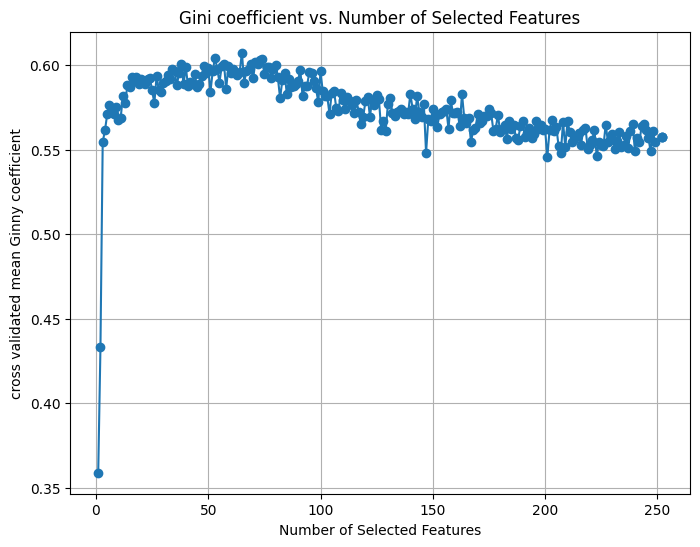

Optimal Threshold: 0.0096
Number of Selected Features: 65
Gini coef at Optimal Threshold: 0.6072


Selected features are: 

ampl_score  del_score  mean.GC.content  total_n_partners.trans  total_n_ohnologs.mmpaper_trans
dist.to.closest.FGS  Length_Counts.E1  Length_Counts.E12  Length_Counts.E13  Length_Counts.E14
Length_Counts.E15  Length_Counts.E16  Length_Counts.E17  Length_Counts.E18  Length_Counts.E2
Length_Counts.E21  Length_Counts.E22  Length_Counts.E23  Length_Counts.E25  Length_Counts.E3
Length_Counts.E4  Length_Counts.E5  Length_Counts.E8  all.int.trans_IntINSIDER  genes.bin
partners.trans  dist.to.closest.OG  dist.to.closest.TSG  distance.to.centromere  distance.to.telomere
Density.complex.proteins  Centromere_Length  20_18  22_37  16_87
2_15  8_50  9_10  10_123  22_40
7_82  9_91  1_237  6_163  7_45
7_22  8_43  7_139  2_108  17_57
1_121  11_88  7_84  1_236  2_197
12_17  8_52  6_82  11_80  20_24
11_66  8_82  20_36  11_87  log2smoothed


Discarded features are: 

total_n_PPIs.tr

In [34]:
feature_names = model.feature_names_in_
feature_importances_shap = np.mean(np.mean(np.abs(explainer.shap_values(X_train)), axis = 0),axis = 1)

X_train_reduced, X_test_reduced, selected_features = feature_selector_shap(feature_names, feature_importances_shap, 
                                                                            model, X_train, X_test, y_train, 
                                                                            inner_cv = inner_cv,
                                                                            plot = True, verbose = True)

In [35]:
features_to_discard = [feature for feature in selected_features if feature not in selected_features_in_at_least_one_cv]

In [36]:
print(f"Dropping columns never selected during Nested Cross Validation: {features_to_discard}")

Dropping columns never selected during Nested Cross Validation: ['total_n_partners.trans', 'partners.trans', 'Density.complex.proteins', '20_18', '22_37', '16_87', '9_10', '10_123', '1_237', '7_22', '7_139', '1_121', '1_236', '12_17', '8_52', '6_82', '8_82', '11_87']


In [37]:
X_train_reduced = X_train_reduced.drop(features_to_discard, axis = 1)
X_test_reduced = X_test_reduced.drop(features_to_discard, axis = 1)

In [38]:
opti_fs = sk.model_selection.RandomizedSearchCV(estimator = model, 
                                                param_distributions = search_space_grid, 
                                                cv = inner_cv, 
                                                n_jobs = n_jobs_sk,
                                                n_iter = n_iter_rsearch,
                                                random_state = hypertune_random_state_rsearch, 
                                                verbose = 0, refit = True)
opti_fs.fit(X_train_reduced, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=0.6991241690789752,
                                           colsample_bynode=None,
                                           colsample_bytree=0.9199415802355813,
                                           device='cpu',
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None,
                                           feature_weights=None,
                                           gamma=0.22369203185335856,
                                           grow_polic...
                                        'objective': ['multi:softmax'],
                                        'reg_alpha': [0.14549582577894687,
                                                      0.014900242190610162,
                                                      0.0029949916204736644,
                                                      10.0,
                                                      0.011721722669367739],
                                        'reg_lambda': [0.5203411655062483,
                                                       0.2669840207965698,
                                                       0.12856312359450586,
                                                       4.225869278060716,
                                                       7.319717673230659],
                                        'subsample': [0.8543582000448856, 1.0,
                                                      0.8817406940448107,
                                                      0.9309426393172106,
                                                      0.8596580193924419]},
                   random_state=49574)

In [39]:
model_fs = opti_fs.best_estimator_

In [40]:
best_params_fs = opti_fs.best_params_

In [41]:
for k,v in best_params_fs.items():
    print(f"{k}: {v}")

subsample: 0.8817406940448107
reg_lambda: 7.319717673230659
reg_alpha: 0.14549582577894687
objective: multi:softmax
n_estimators: 427
min_child_weight: 1
max_depth: 8
max_delta_step: 6
learning_rate: 0.07625465681914323
gamma: 0.8080965169069582
eval_metric: mlogloss
colsample_bytree: 0.7704026156917849
colsample_bylevel: 0.6327579477475511
booster: gbtree


## Evaluate Model Performances

In [42]:
f1_macro = sk.metrics.make_scorer(sk.metrics.f1_score, average="macro")
precision_macro = sk.metrics.make_scorer(sk.metrics.precision_score, average="macro")
recall_macro = sk.metrics.make_scorer(sk.metrics.recall_score, average="macro")

In [43]:
accuracy_array_fs = np.mean(sk.model_selection.cross_val_score(model_fs, X_train_reduced, y_train, cv = outer_cv, scoring = "accuracy"))
f1_array_fs = np.mean(sk.model_selection.cross_val_score(model_fs, X_train_reduced, y_train, cv = outer_cv, scoring = f1_macro))
precision_array_fs = np.mean(sk.model_selection.cross_val_score(model_fs, X_train_reduced, y_train, cv = outer_cv, scoring = precision_macro))
recall_array_fs = np.mean(sk.model_selection.cross_val_score(model_fs, X_train_reduced, y_train, cv = outer_cv, scoring = recall_macro))
roc_auc_array_fs = np.mean(sk.model_selection.cross_val_score(model_fs, X_train_reduced, y_train, cv = outer_cv, scoring = "roc_auc_ovr"))

proba_predictions_fs = sk.model_selection.cross_val_predict(model_fs, X_train_reduced, y_train, cv = outer_cv, method= "predict_proba")
class_array_fs = sk.model_selection.cross_val_predict(model_fs, X_train_reduced, y_train, cv = outer_cv, method= "predict")

In [44]:
label_binarizer = sk.preprocessing.LabelBinarizer().fit(y_train)
y_onehot_train = label_binarizer.transform(y_train)
n_classes = y_onehot_train.shape[1]
target_names = np.unique(y_train)

In [45]:
fpr, tpr, roc_auc = dict(), dict(), dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = sk.metrics.roc_curve(y_onehot_train[:, i], proba_predictions_fs[:, i])
    roc_auc[i] = sk.metrics.auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = sk.metrics.auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score: {roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score: 0.82


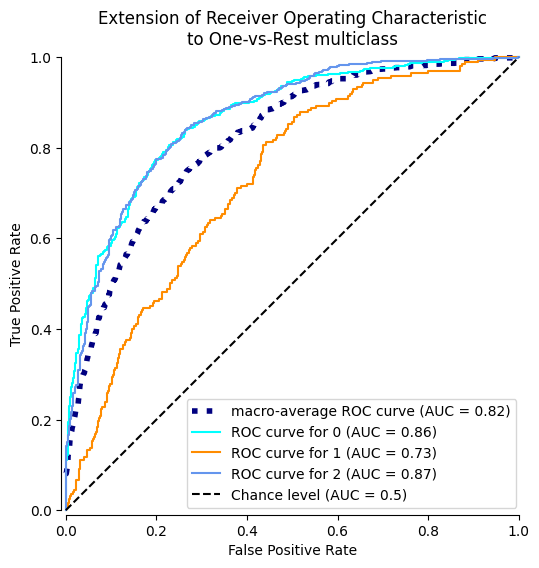

In [46]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    sk.metrics.RocCurveDisplay.from_predictions(
        y_onehot_train[:, class_id],
        proba_predictions_fs[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
        despine=True,
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)

## Store Variables for later

In [47]:
pickle.dump(X_train_reduced,open(X_train_filename,"wb"))
pickle.dump(X_test_reduced,open(X_test_filename,"wb"))
pickle.dump(y_train,open(y_train_filename,"wb"))
pickle.dump(y_test,open(y_test_filename,"wb"))
pickle.dump(bin_train,open(bin_train_filename,"wb"))
pickle.dump(bin_test,open(bin_test_filename,"wb"))
pickle.dump(model_fs,open(model_filename,"wb"))